In [1]:
#| default_exp learner

In [2]:
import logging
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

<span style='color:Blue'> 
NB: JH made changes to the code AFTER the lesson where this was presented.
To find those changes (made to the code in the last week), we 
can go to the course repo, add /compare in GitHub, and compare across different things.
One of the examples they provide is to compare across different times, e.g., 
the master Branch now versus one day ago.
To change that to vs. 7 days ago, change in the URL to 7, i.e., to see the commits changes from last week. 
</span>

In [3]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from warnings import warn

from torch import tensor,nn,optim
from torch.utils.data import DataLoader, default_collate
#from torch.utils.data.dataloader import , default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

### Preliminaries
From previous notebooks.

In [5]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
x,y = ds_builder.info.features
x, y

('image', 'label')

In [6]:
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

We define an `@inplace` transform `transformi(b)` which given a batch `b` 
converts each image `b[x]` into a tensor with [to_tensor](https://pytorch.org/vision/stable/generated/torchvision.transforms.functional.to_tensor.html).
<br>
`tds` is the transformed dataset dictionary, via Huggingface [with_transform](https://huggingface.co/docs/datasets/v2.8.0/package_reference/main_classes#datasets.Dataset.with_transform).

In [11]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

tds = dsd.with_transform(transformi)

`class DataLoaders:` defined similar to before.
We pass 2 dataloaders `dls[:2]` and store them in `.train`, `.valid`.
<br>
We define a `@classmethod` `from_dd()`, that calls `DataLoader` on each of the `ds` 
(dataset dictionary items), with the `batch_size` and instantiate the class.
NB: `cls` is the corresponding `self`.
<br>
Python's [@classmethod](https://docs.python.org/3/library/functions.html#classmethod)
allows us to later write `DataLoaders.`something, e.g., `DataLoaders.from_dd`.
NB: 
We could have put this in `__init__()`.
Nothing on the device because that didn't work (previous notebook).

In [13]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds), **kwargs) for ds in dd.values()])

We create `dls`, an instance of `Dataloaders` with parallel processing.

In [18]:
bs = 1024
dls = DataLoaders.from_dd(dd=tds, batch_size=bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]   # xb has bs images, yb has bs labels

(torch.Size([1024, 784]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

### Basic Learner

A simple learner `BasicLearner` that fits on one screen and replaces our `fit` function.
<mark> A learner is something that is going to train or learn a particular `model`,
using a particular set of data loaders `dls`, loss function `loss_func`, learning rate `lr`, optimization function `opt_func`. </mark> <br>
To avoid the boilerplate of storing each of these items separately, we call `fc.store_attr()` in `__init__`.
```Python
 def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()
```
Lets look first at the `fit()` method.
```Python
   def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)
```            
It has `.accs` for keeping track of accuracy (for classification where we can use accuracy), `.losses`, and `.ns`. 
We put the `model` on the `def_device`, create the optimizer `opt`, store how many `n_epochs` we're going through.
Then for each `epoch` we call the `one_epoch` function, first to do train (`True`) and then for evaluation (`False`).
```Python
def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
```
In `one_epoch` we set `model.training` to training/validation mode, 
and set `dl` to the `train` or `valid` dataset accordingly.  
Using `enumerate(dl)` we go through each `batch` in the `dl` dataloader and call `one_batch()`.
<br>
`one_batch()` saves the `xb` and `yb` parts of the batch, 
calls the `.model` saving the results in `.preds`, 
calls the loss function `loss_func` with the `.preds` and targets `yb`.
If training `model.training=True` it does the backward pass.
Then it calculate the statistics `calc_stats` for accuracy, which are printed at the end of `one_epoch`.

In [23]:
class BasicLearner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

`BasicLearner` is not very flexible but it is a good start, all on one screen (31 LoCs), to see what a Learner is.
It can't help, e.g., with the Autoencoder, because there's no way 
of changing which things are used for predicting with or for calculating with.
We can use `BasicLearner` ONLY for things that involve accuracy with a multi-class classification.

Lets define a simple `model` to test `BasicLearner`.

In [24]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

learn = BasicLearner(model, dls, loss_func=F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.194032421875 0.5942666666666667
0 False 1.13867578125 0.6077428571428571


## Callbacks

Default exceptions to be ignored.

In [28]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

Note that in `class Callback(): order = 0`
so all callbacks have the default order of zero unless we ask otherwise.

In [29]:
#|export
class Callback(): order = 0

`run_cbs` will run all the `cb` callbacks in `cbs` in order.
It uses [getattr()](https://docs.python.org/3/library/functions.html#getattr) to retrieve the `method` name in the `cb`.
(`getattr`: Get a named attribute from an object; `getattr(x, 'y')` is equivalent to `x.y`).
If the method exists, it calls it.

In [33]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

### Simple Callback CompletionCB
Before we look at how callbacks work, let's run a simple callback `CompletionCB`.
Before we start fitting a new model it sets its `count=0`, and after each batch it increments `count`.
`After_fit` it will print out `count`, how many batches we've done.

In [34]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

(Before we even train a model) lets run manually `before_fit`,
`after_batch`, and `after_fit` using `run_cbs`, to make sure they work as we want.
We set the list of `cbs` to have a single member, `CompletionCB()`.

In [35]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'nonexistent')
run_cbs(cbs, 'after_fit')

Completed 1 batches


As expected, it printed "Completed 1 batches". 
`run_cbs` went through each `cb` in the cbs list. (there's only one),
used `getattr` to find an attribute with the corresponding name, (e.g., `before_fit`),
and called it. Notice how it ignored `nonexistent`,

<mark> NB: **Don't just run code willy-nilly but understand it by experimenting with it. Don't just use what is already created** </mark> <br>
Lets do it all manually: create a callback `cb` set it to `cbs[0]`, just like later in the learner loop. <br>
Q: What happens if we call `getattr` and pass in the `cb` callback?

In [37]:
cbs = [CompletionCB()]
cb = cbs[0]

getattr(cb, 'after_batch', None)

<bound method CompletionCB.after_batch of <__main__.CompletionCB object at 0x131b4e550>>

A: `getattr` returned a method. 
What happens to that method it gets called? let's try calling it.

In [38]:
getattr(cb, 'before_fit', None)(learn)

when we call the `before_fit` it doesn't do anything interesting.
But if we call `after_batch` and then call `after_fit` it does.

In [39]:
getattr(cb, 'after_batch', None)(learn)

getattr(cb, 'after_fit', None)(learn)

Completed 1 batches


## Basic Callbacks Learner

The BasicLearner wasn't flexible but it hard coded that:
- we can only calculate accuracy and average loss
- we're putting things on a default device
- a single learning rate 

A basic callbacks learner `BasicCBLearner` is an intermediate step.
It is similar to the `BasicLearner`: 
it's got a `fit()`, `one_epoch()`, `one_batch`, which will call the model, etc.
<mark> And a few more things..</mark>
For example, in `fit()`, after creating the optimizer, 
`self.opt = self.opt_func(self.model.parameters(), self.lr)`
`self.opt_func` defaults to `SGD`, as `opt_func=optim.SGD`.
We instantiate `opt`, an SGD object passing in the model's parameters, and the learning rate `lr`.
Before we start looping through `one_epoch` at a time,
it calls `self.callback('before_epoch')` which takes a method name.
It calls `run_cbs`, passes in `cbs` (a list of our callbacks) and the method name `method_nm`.
`run_cbs` sorts the callbacks in their order attribute and invokes the methods.

In [41]:
class BasicCBLearner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()
     
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

Notice that there's a `try:` immediately before every `before_` method and a `except` immediately after every `after_` method.
Each one has a different exception to look for: 
`CancelFitException, CancelEpochException`, and `CancelBatchException`.
These exceptions get ignored, so that any of the callbacks could raise any one of these 3
exceptions to say "I don't want to do this batch please".

### Experimenting with exceptions
The `get_model()` function below creates a `nn.Sequential` model.
We instantiate the `model` and the `learn` and call `fit()`. 
Since the only callback we added was `completionCB`, it just reports the number of batches as expected.

In [56]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

model = get_model()
learn = BasicCBLearner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 69 batches


We now have a trained model, who didn't print any metrics because it does not have any metric callbacks.

`SingleBatchCB(SimpleCB)` after a single batch raises a `cancelEpochException`.
(Could be useful to just run one batch to make sure a model works).

In [43]:
class SingleBatchCB(Callback):
    def after_batch(self, learn): raise CancelEpochException()

We add `SingleBatchCB` to `cbs`, define a `learn` and call `learn.fit` to try it.

In [45]:
learn = BasicCBLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 0 batches


It ran, but nothing happened because it `after_batch` raised `CancelEpochException()` which canceled the Epoch. 
We can make `SingleBatchCB` run second by setting its `order` higher, 
e.g., 1 (default order is 0), and `cbs_run` sorts by `order` attribute.

In [46]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelEpochException()

In [47]:
learn = BasicCBLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 2 batches


**Callbacks** are not "magic", it's just a name we use to refer to callables.
We pass into something that will then call back to that callable at particular times.
There are interesting kinds of callbacks that have multiple methods in them.

## Metrics

Lets define a class `Metric` that can keep track of a metric, e.g., to tell us the accuracy and the loss.
We're going to keep track of all of the actual values `vals` that we're averaging and the number `ns` in each minibatch.
When we `add` a minibatch we call calculate (`calc`).
A subclass should override the parent classes `calc` so it does the calculation there.
We append the result to our list of values, `self.vals.append(self.last)`
and append to `ns` (list of batch sizes) the current batch size, `self.ns.append(n)`.

In [49]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

### Accuracy metric
Lets define, for example, an `Accuracy(Metric)` by defining the calculation `calc`:
the `mean` of how often the input `inps` equals the targets `targs`.

In [50]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

We create `acc` an `Accuracy` metric object, `add` a few batches of inputs and targets,
and get the `acc.value`, i.e., the accuracy.

In [51]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([1, 1, 2, 0, 1]))
acc.value

tensor(0.63)

Notice that `acc.value` is a `@property`, thus we didn't have to put `()` after it to get the calculation to happen.

Another way: create a metric which simply gets the weighted average.
`add` 0.6 (loss with batch size of 32); `add` 0.9 (loss w/batch size of 2);
That gives us a weighted average loss of 0.62 which is equal to the (manual) weighted average calculation.

In [55]:
wa = Metric()
wa.add(0.6, n=32)
wa.add(0.9, n=2)
wa.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

We can defined a metric class to create any metric by overwriting `calc`.
Or we could create things from scratch, as long as they have an add and a value.

## Some callbacks to print out, etc

Lets define a `deviceCB(Callback)`, to use a GPU, without the complications we had before,
i.e., to allow multiple processes in the dataloader and also use the GPU device. 
<br>
`before_fit()` puts the model onto the default device, and `before_batch()` put the batch onto the device.
NB: In the learner everything is put inside self which means it's all modifiable.

We check that the `deviceCB` callback works by using the old learner, replacing `SingleBatchCB()` by  `deviceCB()`.

In [53]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [57]:
learn = BasicCBLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), CompletionCB()])
learn.fit(1)

Completed 69 batches


### Torcheval
We don't have to write every single metric because they
already exist in [torcheval](https://pytorch.org/torcheval/stable/), 
a Pytorch project that we can `pip install torcheval`. 
It has a similar approach to ours, with `.update` and `.compute`, and provides a list of metrics to pick from.
As we've already built our own we can now use theirs.
Lets use 
[MulticlassAccuracy](https://pytorch.org/torcheval/stable/generated/torcheval.metrics.MulticlassAccuracy.html#torcheval.metrics.MulticlassAccuracy).

In [58]:
from torcheval.metrics import MulticlassAccuracy, Mean

We create a `MulticlassAccuracy` metric and we pass in a minibatch of inputs and targets and then `update` and `compute`.
Half of them match so the accuracy is .5

In [59]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

We call `reset` at the start of each epoch.
After `reset`, `compute` returns `nan` because accuracy is meaningless when we don't have any data yet.

In [60]:
metric.reset()
metric.compute()

tensor(nan)

NB: Some`torcheval` metrics didn't work correctly when tensors were on the GPU and had `requires_grad`.
Created a `to_cpu` function that calls `detach()` to remove 
all the computation history used to calculate a gradient, and also puts the tensor on the CPU.
It'll do the same for dictionaries, lists and tuples of tensors.

In [61]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

### `MetricsCB(Callback)`

For the `MetricsCB(Callback)` we pass-in the names and objects of the metrics to track and print.
As a shortcut, if we didn't want to write `accuracy=` we could just
remove that and run it, and then it will give it a name and it'll use the same name as the class. <br>
`for o in ms: metrics[type(o).__name__] = o`
We can either pass in `*ms` a list of positional arguments which will be turned into a tuple.
Or we can pass in named arguments, which will be turned into a dictionary.
If we pass in positional arguments, it turns them into named arguments in the dictionary 
by grabbing the name from their type.
We'll store that in: `self.metrics = metrics`
We make a `copy()` of the `metrics` into a `all_metrics` dictionary. 
Copy allows us to change one without changing the other.
And add an additional metric to the `all_metrics`, the `loss` as the weighted average of the losses:
`self.all_metrics['loss'] = self.loss = Mean()`
<br>
In `before_fit` we tell the Learner `learn` that we are the metrics callback: `learn.metrics = self`.
In `before_epoch` we reset all the metrics: `[o.reset() for o in self.all_metrics.values()]`.
In `after_epoch` we create a dictionary of the keys `k` and values `v` which 
we want to print out, and call `_log` which (for now) just prints them. 
In `after_batch` we take the input and target to the CPU.
Then go through each `m` of our `metrics.values()` and call `m.update`, i.e., *"here's a batch of data"*, 
Then call `loss.update` for the special `loss` metric, passing in the actual `loss` and the minibatch size.

In [67]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
#       import pdb; pdb.set_trace()
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

Below we create `metrics`, a `MetricsCB` object that's going to calculate and print out `accuracy`.
We pass `metrics` as a `cbs` to the `Learner`.
During `learn.fit()`, it's going to print the `accuracy`, `loss`, `epoch` number, and whether it's training or evaluating.

In [68]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = BasicCBLearner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.611', 'loss': '1.156', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.697', 'loss': '0.843', 'epoch': 0, 'train': 'eval'}


## Flexible Learner

Class `__CbCtxInner` implements a context manager.
It is passed the calling class `outer` e.g. the Learner's `self`, and a name of the method.
In `__enter__`  it calls `outer.callback(f'before_{self.nm}')`,  where e.g., `{nm}` is fit. 
In `__exit__` it needs to grab the `CancelFitException`.
All global variables in Python "live" in a dictionary returned by `globals()`.
We look up in that dictionary the variable called `Cancel{...}Exception`.
We then check for it, and if it is not we raise, and if it is we ignore it.
`finally:` we call the `cleanup_` callback. 

In [69]:
#|export
class _CbCtxInner:
    def __init__(self, outer, nm): self.outer,self.nm = outer,nm
    def __enter__(self): self.outer.callback(f'before_{self.nm}')
    def __exit__ (self, exc_type, exc_val, traceback):
        chk_exc = globals()[f'Cancel{self.nm.title()}Exception']
        try:
            if not exc_type: self.outer.callback(f'after_{self.nm}')
            return exc_type==chk_exc
        except chk_exc: pass
        finally: self.outer.callback(f'cleanup_{self.nm}')

In `one_epoch()` (below) we grab the training or validation set based on the argument `train`,
and then use the context manager for `epoch`, `cb_ctx('epoch')`.
Loop through each `batch` in the `dl` dataloader. 
Then for each batch in `dl` using the `batch` context..
**interesting**
we call `self.predict(), self.get_loss()` and, if we're training, `self.backward(), self.step()`, and `self.zero_grad()`.
<br>
Previously we called `self.model()`, `self.loss()`, etc., but now we call instead `self.predict()`, `self.get_loss()`, etc.
But these are not defined here, so how does it work?
We do it for flexibility, so we can change them (`predict`, `get_loss`, etc.) for different situations.
<br>
What happens if we call `self.predict()` and it doesn't exist?
It doesn't necessarily cause an error as it calls `__getattr__`.
If `name` is in the special list ('predict','get_loss','backward','step','zero_grad') it `return partial(self.callback, name)`. 
else, `name` is not on the list, then it `raise AttributeError(name)`.
To make this work, as before, we define a callback (`TrainCB`) which implements the 5 in the list, and pass it along as a `cbs`.

In [70]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    def cb_ctx(self, nm): return _CbCtxInner(self, nm)

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.callback('after_backward')
                        self.step()
                        self.callback('after_step')
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

Notice Python's flexibility. If any of the 5 in the list don't exist it will use `__getattr__` 
to find them  in the callbacks.
We could have multiple callbacks that define these things and then chain them together.

**HW Q**: Why we didn't have to say `with torch.nograd` but instead call `torch.nograd()`
Great if you understand why that works/what it does, will help understanding of decorators.

In `TrainCB` they're almost the same as in `BasicCBLearner`, but must have `learn.` in front of each (preds, loss, etc.),
because this is a callback, it's not the learner.
NB: JH also added `self.n_inp` to `TrainCB` below after the lesson, so we can train models with more than one input or output.

In [71]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

Lets now test the Flexible learner...

In [73]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

{'accuracy': '0.608', 'loss': '1.161', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.694', 'loss': '0.815', 'epoch': 0, 'train': 'eval'}


## Progressbar

Let's create a `ProgressCB(Callback)` to show our current loss using [Fastprogress](https://github.com/fastai/fastprogress).
<br>
Before we `fit` we set `learn.epochs`, so instead of a normal range it is a progress bar around a range `master_bar(self.learn.epochs)`.
<br>
`MetricsCB` had a `_log` method, (instead of just `print`), so we can now replace how metrics are displayed.
If the learner has a `metrics` attribute, `hasattr(self.learn, 'metrics')` we replace the `_log` method 
with ours which will write to the progress bar `self.mbar.write(str(d))`.
(We can modify how metrics are displayed, e.g., replace the bar with an HTML table, (w/FirstProgress).
<br>
`Before_epoch` we do a similar thing: the `learn.dl` iterator we change to have a `progress_bar` wrapped around it.
And then `after_batch` we set `learn.dl.comment = f'{learn.loss:.3f}'`, so it will show `loss` on the progress bar.
And if we've asked to plot `if self.plot` then we will append the losses to a list of losses 
and we `update_graph` with the losses and the batch numbers.

In [74]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

Let's get the model and train and in real time see updates to the graph.

In [75]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.625,1.156,0,train
0.700,0.810,0,eval


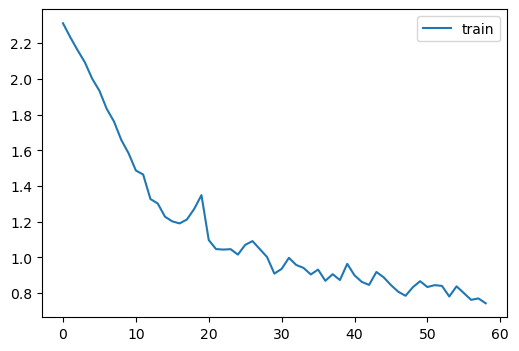

In [76]:
learn.fit(1)

We now have a working flexible learner, which we can understand, 
and a framework which we control and can make it work how we want to.
Ideally not by changing the learner itself, but by creating callbacks.
We haven't added inference yet, but that shouldn't be too much to add.

## TrainLearner and MomentumLearner

There's another way we could make the list of 5 "exist": we could subclass the Learner.
Let's not use `trainCB` just to show how a subclass would work.
We define a class `TrainLearner(Learner)` as a subclass of `Learner` that implements the same 5 methods as in `trainCB`.
Now we don't need the `self.learn` anymore, because we are "in the" `Learner`, so `self.` suffices.
This way it's never going to end up going to `__getattr__` (which is only called if something doesn't exist).

In [78]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

**TODO: Review if here it is TrainCB or TrainLearner**
Now if we want to use huggingface accelerate, or something that works on huggingface data Styles, dictionary things, etc.,
we can change how it behaves, by creating a callback for training like `TrainCB`.
And if we want everything except one thing to be the same, we can inherit from `TrainCB`.

Lets define `MomentumLearner` which changes `zero_grad` to do something "a bit crazy".
Instead of zeroing the gradients we multiply them by a number, e.g.,  0.85.
Our previous gradients would still be there, but they would be reduced a bit.
Pytorch always adds the gradients to the existing gradients (that's why we normally call zero_grad).
But if instead we multiply the gradients by a number, a parameter, we keep the trail of gradients...
(This is a lot like gradient accumulation callback)
<br>
We add `mom=0.85` to the constructor arguments, and call `super().__init__`.
NB: make sure to call the super classes passing in all the stuff. (We could use delegates for this.)

In [79]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

Below using `MomentumLearner` but there's no `trainCB` in the `cbs` list.
It trains at the same `lr` for the same time, but `loss` improved from 0.8 to 0.55 and `accuracy` from 0.7 to 0.8.
We implemented **momentum**, which can make us reach the destination faster.
Normally for momentum we have to store a complete copy of all the gradients, 
to keep track of a running exponentially waited moving average.
But with the above "trick" we're using the `.grad` themselves to store the
exponentially weighted moving average, obtining an accelerated optimizer and memory savings.

accuracy,loss,epoch,train
0.687,0.930,0,train
0.810,0.542,0,eval


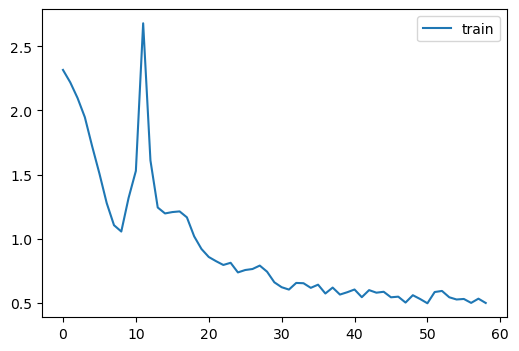

In [80]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## LRFinderCB

Another callback is the learning rate finder `LRFinderCB`, which increases `lr` gradually, 
by an `lr_mult` factor each batch, and plots `loss` against `lr`.
We use it to find how high can `lr` be before `loss` starts getting worse.
We want `lr` roughly where the steepest slope is.
<br>
In `before_fit` we keep track of the points in the plot: `lrs` and `losses`. 
We have to decide when to stop training, when `loss` gets worse and it has "gone off".
JH decided that `loss > self.min*3` is the criteria to stop.
We keep track of the minimum loss (`self.min`), initially set to Infinity (`math.inf`).
<br>
In `after_batch`, if it is not training (no use for `LRfinderCB` during validation), raise `CancelEpochException()`,
which stops it from doing that epoch entirely.
(`one_epoch` will handle this goes straight to the `except` which goes to the end of that code and it's going to skip it.)
<br>
We can grab the `lr` from the dictionary `param_groups` where Pytorch stores the `lr`s.
We've got to keep track of the `loss`, so append it to our list `losses`,
and if it's less than `min`  we've seen, then record it as the `min`.
If it's greater than 3 times `min`, then raise the `cancelFitException` to stop everything.
Finally update `lr` to `lr_mult` times the previous one.
(In Pytorch we have to go through each `param_group`, grab the corresponding`g[lr]` and multiply it.)

In [81]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

The `LRFinderCB()` callback needs to be instantiated first, to be able to grab its learning rates and its losses.
Notice that [plt.xscale](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xscale.html) is used to set the x-axis scale.

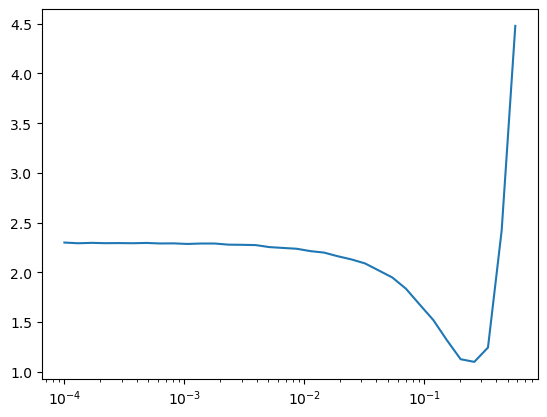

In [85]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale("log")

### LRFinder using Pytorch 
We can implement `LRfinderCB` with a Pytorch learning rate scheduler, `lr_scheduler`, but it won't save much.
The `lr_scheduler` does this one line of code for us:
`for g in self.learn.opt.param_groups: g['lr'] *= self.lr_mult`. 
Lets create a new `LRfinderCB`, using Pytorch's 
[ExponentialLR scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR).
<br>
NB: *the documentation is wrong, claims that it decays the `lr` of each parameter Group by `gamma` 
every epoch but it's not done every epoch.
Pytorch schedulers have a `step` method and the decay happens each time it calls step.*

In [86]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

In `before_fit` we create `self.sched = ExponentialLR(self.learn.opt, self.gamma)`
equal to the scheduler because it's going to be adjusting the learning rates.
It needs access to the optimizer `learn.opt` and the learning rate multiplier `gamma`.
`After_batch` rather than having a loop over the `param_groups` we just do `self.shed.step()`.
<br>
Not gaining much with the Pytorch ExponentialLR scheduler, just the `self.shed.step()`.

In [87]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*self.max_mult:
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

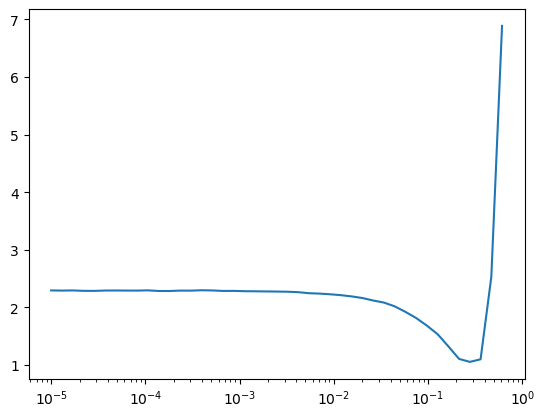

In [88]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

The `@fc.patch` decorator turns a function (e.g., `lr_find`) into a method of the class after `self:` (here `Learner`).
This created a new method `Learner.lr_find`, which calls `self.fit` where `self` is a `learner`,
passing in `max_epochs`, what to start the learning rate `start_lr`, and to use as `cbs` callbacks the `LRFinderCB` callback with the appropriate arguments `gamma` and `max_mult`.

In [89]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

<span style='color:Green'> 
`@patch` is controversial in the Python community.
It is used widely and considered good on other programming languages.
JH doesn't have strong opinion, but here it was useful to add functionality to the `Learner` class.
</span>

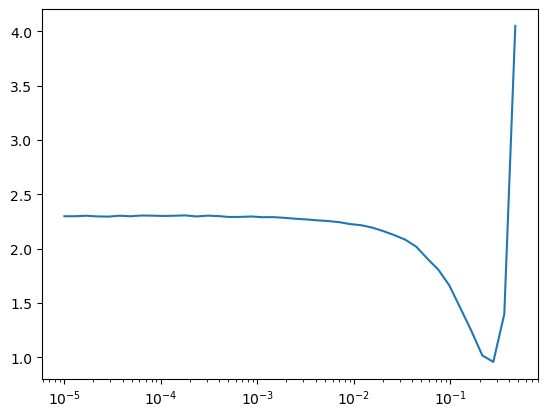

In [90]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

## Export -

In [91]:
import nbdev; nbdev.nbdev_export()